# Transform

Do imports.

In [10]:
import colorsys
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from ae483tools import *

Load data from a flight in which the drone took off, moved in a square, and landed.

In [41]:
raw_data_drone, raw_data_mocap = load_hardware_data('square_high_custom.json')

Resample drone data.

In [42]:
data_drone = resample_data_drone(raw_data_drone, t_min_offset=0.1, t_max_offset=0.)

# t = data_drone['time']
# x_drone = data_drone['stateEstimate.x']
# y_drone = data_drone['stateEstimate.y']
# z_drone = data_drone['stateEstimate.z']
# psi_drone = np.deg2rad(data_drone['stateEstimate.yaw'])
# theta_drone = - np.deg2rad(data_drone['stateEstimate.pitch'])
# phi_drone = np.deg2rad(data_drone['stateEstimate.roll'])

t = data_drone['time']
x_drone = data_drone['ae483log.p_x']
y_drone = data_drone['ae483log.p_y']
z_drone = data_drone['ae483log.p_z']
psi_drone = np.deg2rad(data_drone['ae483log.psi'])
theta_drone = - np.deg2rad(data_drone['ae483log.theta'])
phi_drone = np.deg2rad(data_drone['ae483log.phi'])

Resample mocap data.

In [43]:
resampled_data_mocap = resample_data_mocap(raw_data_mocap, t)

x_mocap = resampled_data_mocap['x']
y_mocap = resampled_data_mocap['y']
z_mocap = resampled_data_mocap['z']
psi_mocap = resampled_data_mocap['yaw']
theta_mocap = resampled_data_mocap['pitch']
phi_mocap = resampled_data_mocap['roll']

Plot $x, y$ data.

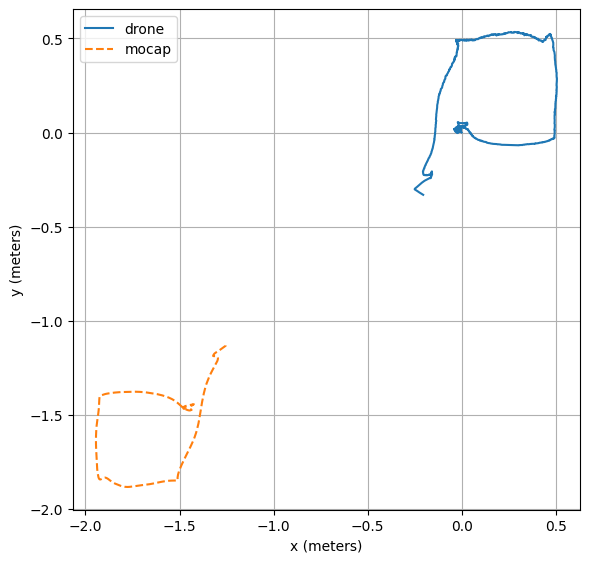

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
ax.plot(x_drone, y_drone, label='drone')
ax.plot(x_mocap, y_mocap, '--', label='mocap')
ax.legend()
ax.grid()
ax.set_aspect('equal')
ax.set_xlabel('x (meters)')
ax.set_ylabel('y (meters)')
plt.show()

Define a function to perform coordinate transformation.

In [45]:
def transform_data_mocap(raw_data):
    # Copy raw data
    data = {}
    for key, val in raw_data.items():
        data[key] = val.copy()

    # Define parameters
    d_1 = 0.0229967 # <-- FIXME
    d_2 = 0.0028033 # <-- FIXME
    
    # Pose of drone body frame in active marker frame
    R_BinA = np.eye(3)                   # <-- FIXME
    p_BinA = np.array([0., 0., -d_1])      # <-- FIXME

    ####################################
    # START OF ANALYSIS AT TIME STEP 0
    #
    
    # Pose of drone world frame in active marker frame (valid t=0 only)
    R_WinA = np.eye(3)                   # <-- FIXME
    p_WinA = np.array([0., 0., -d_1-d_2])      # <-- FIXME

    # Get measurements of (x, y, z) and (psi, theta, phi) from mocap
    x, y, z = data['x'][0], data['y'][0], data['z'][0]
    psi, theta, phi = data['yaw'][0], data['pitch'][0], data['roll'][0]

    # Pose of active marker frame in mocap world frame (valid any t)
    R_AinQ = np.array([[np.cos(psi), -np.sin(psi), 0],
                        [np.sin(psi), np.cos(psi),  0],
                        [0,           0,            1]])@np.array([
                        [np.cos(theta),  0, np.sin(theta)],
                        [0,              1,             0],
                        [-np.sin(theta), 0, np.cos(theta)]])@np.array([
                        [1, 0,                      0],
                        [0, np.cos(phi), -np.sin(phi)],
                        [0, np.sin(phi), np.cos(phi)]])                   # <-- FIXME
    p_AinQ = np.array([x, y, z])      # <-- FIXME
    
    # Pose of drone world frame in mocap world frame (valid t=0 only)
    R_WinQ = R_AinQ @ R_WinA                   # <-- FIXME
    p_WinQ = p_AinQ + R_AinQ @ p_WinA      # <-- FIXME
    
    # Pose of mocap world frame in drone world frame (valid t=0 only)
    R_QinW = (R_WinQ).T                   # <-- FIXME
    p_QinW = -(R_WinQ).T @ p_WinQ      # <-- FIXME

    #
    # END OF ANALYSIS AT TIME STEP 0
    ####################################

    for i in range(len(data['time'])):

        ####################################
        # START OF ANALYSIS AT TIME STEP i
        #

        # Get measurements of (x, y, z) and (psi, theta, phi) from mocap
        x, y, z = data['x'][i], data['y'][i], data['z'][i]
        psi, theta, phi = data['yaw'][i], data['pitch'][i], data['roll'][i]

        # Pose of active marker deck in mocap world frame
        R_AinQ = np.array([[np.cos(psi), -np.sin(psi), 0],
                            [np.sin(psi), np.cos(psi),  0],
                            [0,           0,            1]])@np.array([
                            [np.cos(theta),  0, np.sin(theta)],
                            [0,              1,             0],
                            [-np.sin(theta), 0, np.cos(theta)]])@np.array([
                            [1, 0,                      0],
                            [0, np.cos(phi), -np.sin(phi)],
                            [0, np.sin(phi), np.cos(phi)]])                   # <-- FIXME
        p_AinQ = np.array([x, y, z])      # <-- FIXME

        # Pos of drone in mocap
        p_BinQ = p_AinQ + (R_BinA.T) @ p_BinA
        R_BinQ = R_AinQ @ R_BinA

        # Pose of drone body frame in drone world frame
        R_BinW = R_QinW @ R_BinQ               # <-- FIXME
        p_BinW = p_QinW + R_QinW @ p_BinQ  # <-- FIXME

        # Replace measurements of (x, y, z) and (phi, theta, psi) from mocap
        data['x'][i], data['y'][i], data['z'][i] = p_BinW[0], p_BinW[1], p_BinW[2]              # <-- FIXME
        r = Rotation.from_matrix(R_BinW)
        data['yaw'][i], data['pitch'][i], data['roll'][i] = r.as_euler('ZYX', degrees=False)     # <-- FIXME

        #
        # END OF ANALYSIS AT TIME STEP i
        ####################################
    
    # Return the result
    return data

Apply coordinate transformation to mocap data.

In [46]:
transformed_data_mocap = transform_data_mocap(resampled_data_mocap)

x_mocap = transformed_data_mocap['x']
y_mocap = transformed_data_mocap['y']
z_mocap = transformed_data_mocap['z']
psi_mocap = transformed_data_mocap['yaw']
theta_mocap = transformed_data_mocap['pitch']
phi_mocap = transformed_data_mocap['roll']

Plot $x, y$ data.

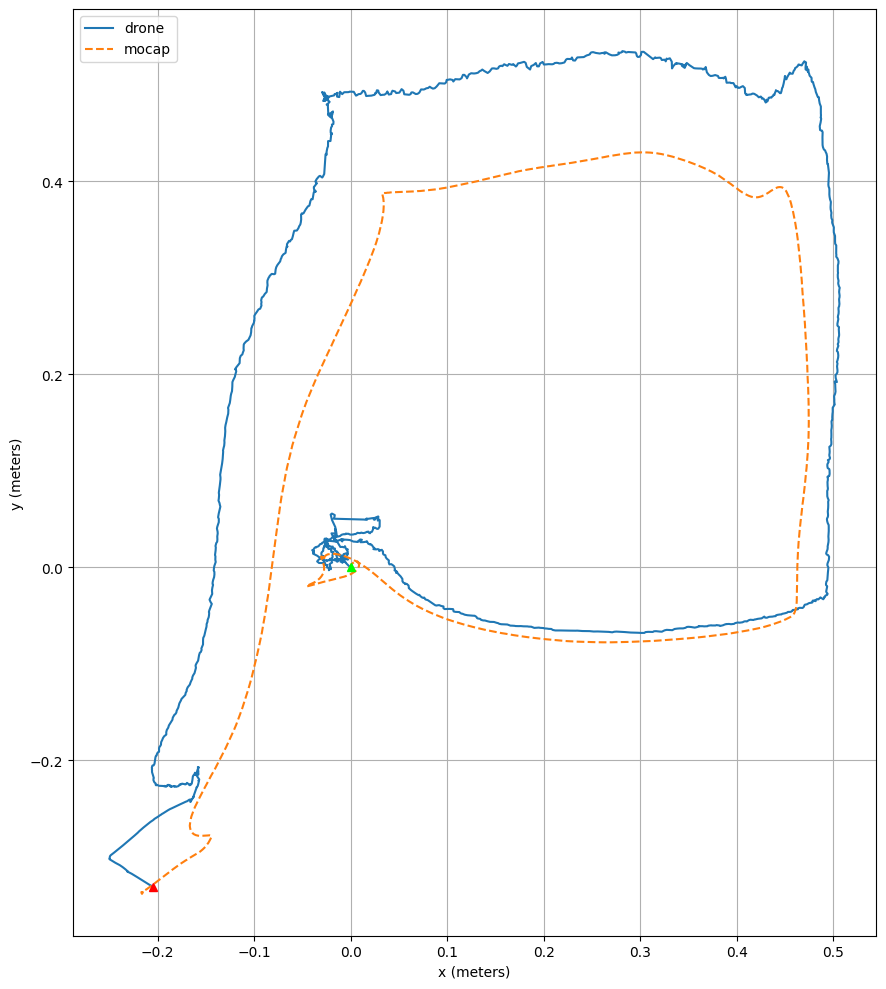

In [47]:
last_index = -1

fig, ax = plt.subplots(1, 1, figsize=(10, 10), tight_layout=True)
ax.plot(x_drone[0:last_index], y_drone[0:last_index], label='drone')
ax.plot(x_mocap[0:last_index], y_mocap[0:last_index], '--', label='mocap')
# ax.plot(x_mocap[0], y_mocap[0], marker='^', color='lime')
# ax.plot(x_mocap[-1], y_mocap[-1], marker='^', color='red')

for i in range(0, last_index//10):
    index = i*10
    # freq = np.pi*2/26
    # R = np.cos(freq*i)/2 + 0.5
    # G = np.cos(freq*i + np.pi/2)/4 + 0.5
    # B = np.cos(freq*i + np.pi)/2 + 0.5
    (r, g, b) = colorsys.hsv_to_rgb(index/last_index, 1.0, 1.0)
    # ax.plot(x_mocap[index], y_mocap[index], marker='o', color=(r, g, b))
    # ax.plot(x_drone[index], y_drone[index], marker='D', color=(r, g, b))

ax.plot(x_drone[0], y_drone[0], marker='^', color='lime')
ax.plot(x_drone[last_index], y_drone[last_index], marker='^', color='red')
ax.legend()
ax.grid()
ax.set_aspect('equal')
ax.set_xlabel('x (meters)')
ax.set_ylabel('y (meters)')
plt.show()

Plot all data.

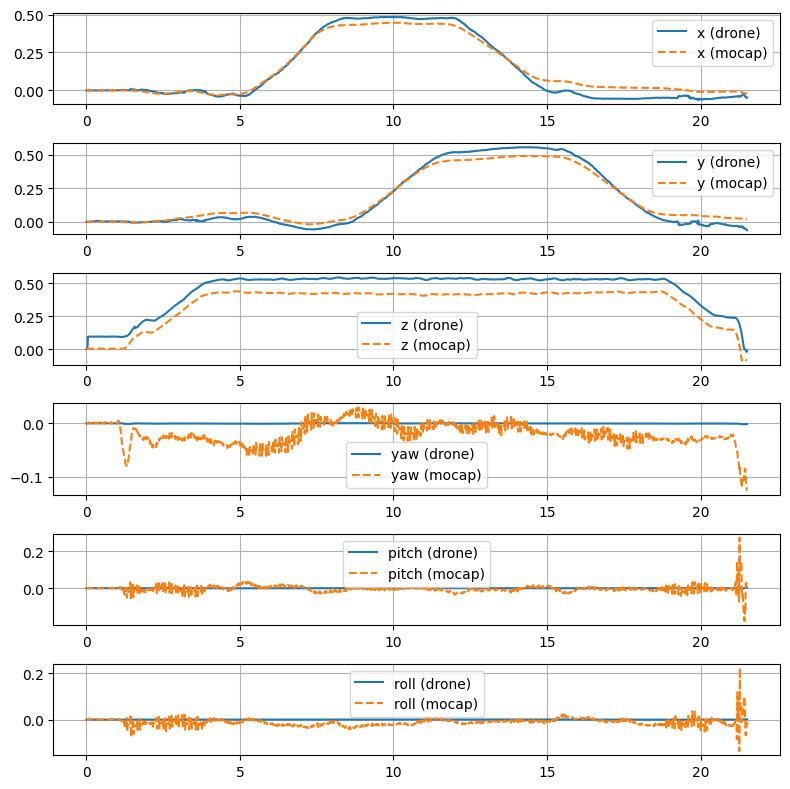

In [19]:
fig, (ax_x, ax_y, ax_z, ax_psi, ax_theta, ax_phi) = plt.subplots(6, 1, figsize=(8, 8), tight_layout=True)

ax_x.plot(t, x_drone, label='x (drone)')
ax_x.plot(t, x_mocap, '--', label='x (mocap)')
ax_x.legend()
ax_x.grid()

ax_y.plot(t, y_drone, label='y (drone)')
ax_y.plot(t, y_mocap, '--', label='y (mocap)')
ax_y.legend()
ax_y.grid()

ax_z.plot(t, z_drone, label='z (drone)')
ax_z.plot(t, z_mocap, '--', label='z (mocap)')
ax_z.legend()
ax_z.grid()

ax_psi.plot(t, psi_drone, label='yaw (drone)')
ax_psi.plot(t, psi_mocap, '--', label='yaw (mocap)')
ax_psi.legend()
ax_psi.grid()

ax_theta.plot(t, theta_drone, label='pitch (drone)')
ax_theta.plot(t, theta_mocap, '--', label='pitch (mocap)')
ax_theta.legend()
ax_theta.grid()

ax_phi.plot(t, phi_drone, label='roll (drone)')
ax_phi.plot(t, phi_mocap, '--', label='roll (mocap)')
ax_phi.legend()
ax_phi.grid()

plt.show()

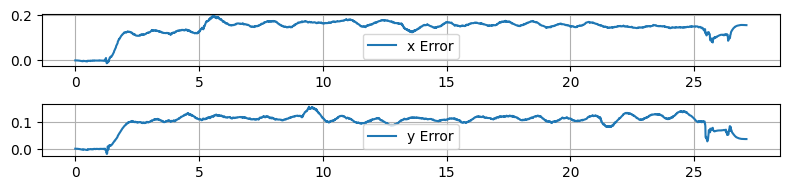

In [36]:
fig, (ax_x_err, ax_y_err) = plt.subplots(2, 1, figsize=(8, 2), tight_layout=True)

ax_x_err.plot(t, x_mocap - x_drone, label='x Error')
# ax_x.plot(t, x_mocap, '--', label='x (mocap)')
ax_x_err.legend()
ax_x_err.grid()

ax_y_err.plot(t, y_mocap - y_drone, label='y Error')
# ax_y.plot(t, y_mocap, '--', label='y (mocap)')
ax_y_err.legend()
ax_y_err.grid()

plt.show()